# M N I S T

С помощью нейронных сетей и методов машинного обучения попробуем решить классическую задачу классификации цифр на датасете [MNIST](https://ru.wikipedia.org/wiki/MNIST_(%D0%B1%D0%B0%D0%B7%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)).

База данных MNIST содержит 60000 изображений для обучения и 10000 изображений для тестирования.

### [1. RandomForest (классическое машинное обучение)](#a001)
accuracy = 0.9477
### 2. Простая нейронная сеть
#### [2.1 Callback](#a003)
#### [2.2 Простая нейронка](#a002) 
accuracy = 0.9658
#### [2.3 Модифицированная нейронка](#a004) 
accuracy = 0.9734 (Mini-Batch normalization, ReLU)
#### [2.3 Модифицированная нейронка+](#a005) 
accuracy = 0.9784 (dropout, Xe_normal initialization, adam)
### 3. Сверточная нейронная сеть
#### [3.1 Сверточная нейронная сеть](#a006)
accuracy = 0.9873
#### [3.2 Сверточная нейронная сеть+](#a007)
accuracy = 0.988 (Mini-Batch normalization, dropout, Xe_normal initialization)
### 4. Другое
#### [4.1 Визуализация архитектуры сети в graphviz](#a008)
#### [4.2 Сохранение и загрузка архитектуры сети и весов](#a009)

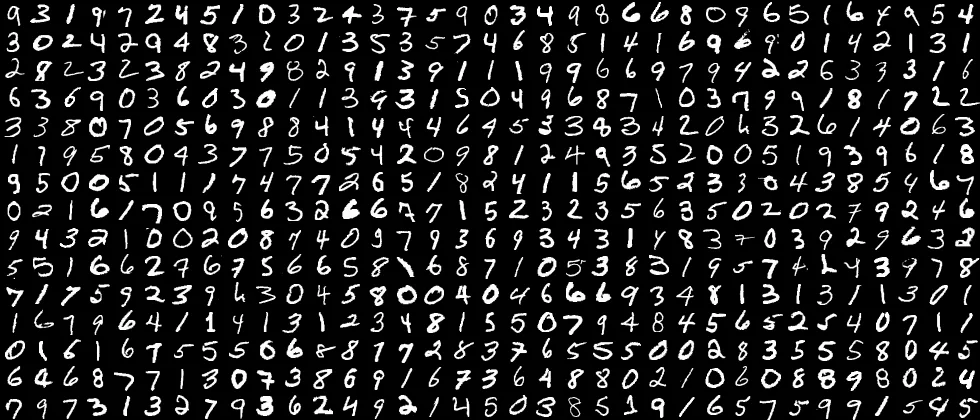

In [1]:
# Import

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf

keras = tf.keras
L = keras.layers

In [2]:
# Загрузка данных

mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

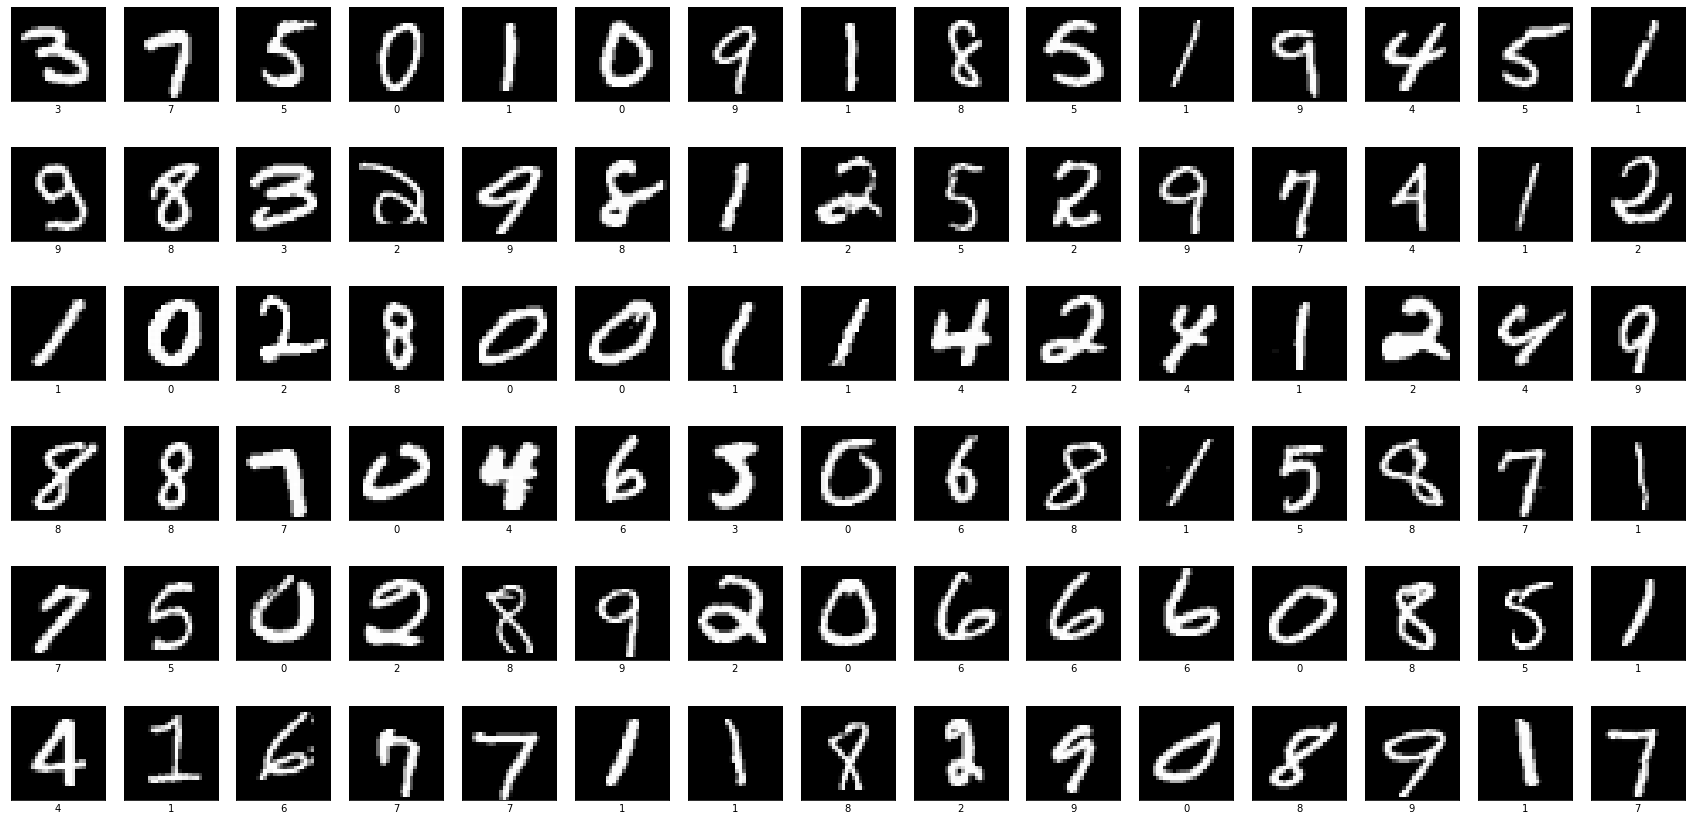

In [4]:
# Посмотрим данные

cols = 15
rows = 6
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(train_labels))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(train_images[random_index, :], cmap = 'gray')
        ax.set_xlabel(train_labels[random_index])
plt.show()

In [5]:
train_images.shape, train_labels.shape, test_images.shape

((60000, 28, 28), (60000,), (10000, 28, 28))

### 1. RandomForest <a name="a001"></a>

In [6]:
rf = RandomForestClassifier()
rf.fit(train_images.reshape(60000,28**2,), train_labels)

C:\conda2020\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [7]:
accuracy_score(test_labels, rf.predict(test_images.reshape(10000,28**2,)))

0.9477

`ВЫВОД:` RandomForest даже без настройки показал весьма хороший результат на тестовой выборке.

Попробуем решить задачу с помощью нейронныйх сетей.

### 2. Простая нейронная сеть
#### 2.1  CallBack<a name="a003"></a>

Добавим раннюю остановку в сеть

In [3]:
# Основной функционал callback

from tensorflow.keras import callbacks

class My_Callback(callbacks.Callback): # Класс My_Callback унаследовал свойства класса Callback 
    def on_train_begin(self, logs={}): # Функция, которая выполняется в начале обучения 
        return None
    def on_train_end(self, logs={}): # Функция, которая выполняется в конце обучения 
        return None
    def on_epoch_begin(self, logs={}):# В начале каждой эпохи 
        return None
    def on_epoch_end(self, epoch, logs={}): # В конце каждой эпохи 
        return None
    def on_batch_begin(self, batch, logs={}): # В начале батча 
        return None
    def on_batch_end(self, batch, logs={}): # В конце батча 
        return None

In [4]:
# Свой callback
class PrintDot(callbacks.Callback):

    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: 
            print('{0} эпох. acc = {1}\tval_acc = {2}'.format(epoch, logs['acc'], logs['val_acc']))
        print('.', end='')

In [5]:
# Подгружаем раннюю остановку
from keras.callbacks import EarlyStopping

# Прикажем модели останавливать обучение, когда качество на валидации не будет улучшаться в течение 8 эпох
early_stopping_monitor = EarlyStopping(patience = 10)

Using TensorFlow backend.


Зададим архитектуру нейронной сети <a name="a002"></a>

In [29]:
# Простая нейронная сеть

snn = keras.Sequential(name = 'simple_neural_network_1')
snn.add(L.Input(shape = (28,28)))
snn.add(L.Flatten())
snn.add(L.Dense(256, activation = 'tanh'))
snn.add(L.Dense(64, activation = 'tanh'))
snn.add(L.Dense(10, activation = 'softmax'))

In [30]:
snn.summary()

Model: "simple_neural_network_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_25 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_26 (Dense)             (None, 10)                650       
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


In [31]:
snn.compile(loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [32]:
hist_snn = snn.fit(x=train_images, y=train_labels, batch_size=10_000, epochs=100, verbose=2, 
        validation_split=0.2, callbacks=[early_stopping_monitor])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 - 1s - loss: 1.6822 - acc: 0.4811 - val_loss: 0.8612 - val_acc: 0.7473
Epoch 2/100
48000/48000 - 0s - loss: 0.7906 - acc: 0.7726 - val_loss: 0.5760 - val_acc: 0.8624
Epoch 3/100
48000/48000 - 0s - loss: 0.5621 - acc: 0.8558 - val_loss: 0.4842 - val_acc: 0.8777
Epoch 4/100
48000/48000 - 0s - loss: 0.4802 - acc: 0.8745 - val_loss: 0.4185 - val_acc: 0.8927
Epoch 5/100
48000/48000 - 0s - loss: 0.4218 - acc: 0.8894 - val_loss: 0.3807 - val_acc: 0.9003
Epoch 6/100
48000/48000 - 0s - loss: 0.3857 - acc: 0.8947 - val_loss: 0.3514 - val_acc: 0.9032
Epoch 7/100
48000/48000 - 0s - loss: 0.3618 - acc: 0.8983 - val_loss: 0.3508 - val_acc: 0.9025
Epoch 8/100
48000/48000 - 0s - loss: 0.3344 - acc: 0.9084 - val_loss: 0.3110 - val_acc: 0.9128
Epoch 9/100
48000/48000 - 0s - loss: 0.3082 - acc: 0.9137 - val_loss: 0.2926 - val_acc: 0.9191
Epoch 10/100
48000/48000 - 0s - loss: 0.2818 - acc: 0.9229 - val_loss: 0.2696 - val_acc: 0.9246

Epoch 86/100
48000/48000 - 0s - loss: 0.0330 - acc: 0.9909 - val_loss: 0.1185 - val_acc: 0.9659
Epoch 87/100
48000/48000 - 0s - loss: 0.0341 - acc: 0.9908 - val_loss: 0.1294 - val_acc: 0.9624
Epoch 88/100
48000/48000 - 0s - loss: 0.0377 - acc: 0.9892 - val_loss: 0.1294 - val_acc: 0.9620
Epoch 89/100
48000/48000 - 0s - loss: 0.0362 - acc: 0.9895 - val_loss: 0.1236 - val_acc: 0.9638
Epoch 90/100
48000/48000 - 0s - loss: 0.0342 - acc: 0.9902 - val_loss: 0.1233 - val_acc: 0.9642
Epoch 91/100
48000/48000 - 0s - loss: 0.0342 - acc: 0.9904 - val_loss: 0.1225 - val_acc: 0.9643
Epoch 92/100
48000/48000 - 0s - loss: 0.0334 - acc: 0.9909 - val_loss: 0.1402 - val_acc: 0.9586
Epoch 93/100
48000/48000 - 0s - loss: 0.0439 - acc: 0.9856 - val_loss: 0.1305 - val_acc: 0.9630
Epoch 94/100
48000/48000 - 0s - loss: 0.0321 - acc: 0.9913 - val_loss: 0.1239 - val_acc: 0.9649
Epoch 95/100
48000/48000 - 0s - loss: 0.0282 - acc: 0.9925 - val_loss: 0.1249 - val_acc: 0.9631
Epoch 96/100
48000/48000 - 0s - loss: 0.

In [33]:
accuracy_score(test_labels, snn.predict_classes(test_images))

0.9658

`ВЫВОД:` Модель показала точность немного выше (на 2%, чем RandomForest)

In [34]:
hist_snn.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [36]:
# Визуализируем процесс обучения, напишем функцию для визуализации

def visualizer(hist):
    # hist - лог процесса обучения сетки
    fig, axes = plt.subplots(1,2, figsize = (15,6))
    axes[0].plot(hist.history['acc'], label = 'train')
    axes[0].plot(hist.history['val_acc'], label = 'test')
    axes[0].set_title('accuracy')
    axes[0].legend()
    axes[0].set_xlabel('epochs')

    axes[1].plot(hist.history['loss'],label = 'train')
    axes[1].plot(hist.history['val_loss'], label = 'test')
    axes[1].set_title('loss')
    axes[1].legend()
    axes[1].set_xlabel('epochs')

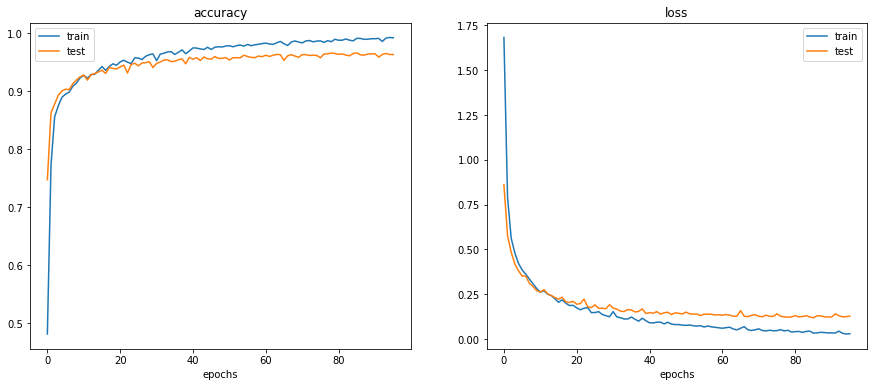

In [37]:
visualizer(hist_snn)

#### Немного модифицируем сетку <a name="a004"></a>
* Нормализуем вход на отрезок [0;1]
* Добавим mini-batch normalization
* Заменим функцию активации на ReLU

In [40]:
snn2 = keras.Sequential(name = 'simple_neural_network_2')
snn2.add(L.Input(shape = (28,28)))
snn2.add(L.Flatten())
snn2.add(L.Dense(256, activation = 'relu'))
snn2.add(L.BatchNormalization())
snn2.add(L.Dense(64, activation = 'relu'))
snn2.add(L.BatchNormalization())
snn2.add(L.Dense(10, activation = 'softmax'))

snn2.compile(loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

hist_snn2 = snn2.fit(x=train_images/255, y=train_labels, batch_size=10_000, epochs=200, verbose=0, 
        validation_split=0.2, callbacks=[early_stopping_monitor, PrintDot()])

0 эпох. acc = 0.6441875100135803	val_acc = 0.6855833530426025
..........10 эпох. acc = 0.981291651725769	val_acc = 0.9252499938011169
..........20 эпох. acc = 0.996916651725769	val_acc = 0.950083315372467
..........30 эпох. acc = 0.9999374747276306	val_acc = 0.9611666798591614
..........40 эпох. acc = 1.0	val_acc = 0.9653333425521851
..........50 эпох. acc = 1.0	val_acc = 0.9704999923706055
..........60 эпох. acc = 0.999958336353302	val_acc = 0.971750020980835
..........70 эпох. acc = 1.0	val_acc = 0.9734166860580444
..........80 эпох. acc = 0.9928333163261414	val_acc = 0.9652500152587891
....

In [41]:
accuracy_score(test_labels, snn2.predict_classes(test_images/255))

0.9734

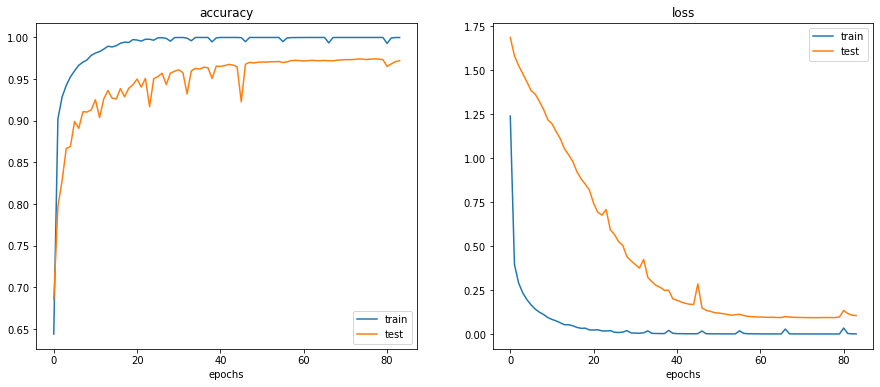

In [42]:
visualizer(hist_snn2)

`ВЫВОД:` Сетка обучается дольше, а результат точность лучше (на 1%)

#### Попробуем улучшить сеть еще <a name="a005"></a>
* Добавим dropOut
* Заменим RMSprop на adam

In [43]:
snn3 = keras.Sequential(name = 'simple_neural_network_3')
snn3.add(L.Input(shape = (28,28)))
snn3.add(L.Flatten())
snn3.add(L.Dense(256, activation = 'relu'))
snn3.add(L.Dropout(0.2))
snn3.add(L.BatchNormalization())
snn3.add(L.Dense(64, activation = 'relu'))
snn3.add(L.Dropout(0.2))
snn3.add(L.BatchNormalization())
snn3.add(L.Dense(10, activation = 'softmax'))

snn3.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

hist_snn3 = snn3.fit(x=train_images/255, y=train_labels, batch_size=10_000, epochs=200, verbose=0, 
        validation_split=0.2, callbacks=[early_stopping_monitor, PrintDot()])

0 эпох. acc = 0.3324166536331177	val_acc = 0.6567500233650208
..........10 эпох. acc = 0.9302083253860474	val_acc = 0.9193333387374878
..........20 эпох. acc = 0.9587708115577698	val_acc = 0.953249990940094
..........30 эпох. acc = 0.9708750247955322	val_acc = 0.9635000228881836
..........40 эпох. acc = 0.9797499775886536	val_acc = 0.9696666598320007
..........50 эпох. acc = 0.9855208396911621	val_acc = 0.9723333120346069
..........60 эпох. acc = 0.9889583587646484	val_acc = 0.9745000004768372
..........70 эпох. acc = 0.9917083382606506	val_acc = 0.9754999876022339
..........80 эпох. acc = 0.9938333630561829	val_acc = 0.9760000109672546
..........90 эпох. acc = 0.9950208067893982	val_acc = 0.9770833253860474
..........100 эпох. acc = 0.9955624938011169	val_acc = 0.9772499799728394
..........110 эпох. acc = 0.9966041445732117	val_acc = 0.9778333306312561
........

In [44]:
accuracy_score(test_labels, snn3.predict_classes(test_images/255))

0.9784

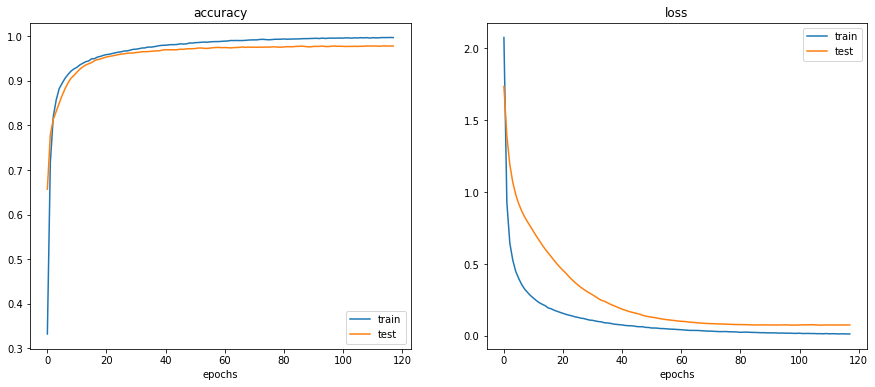

In [45]:
visualizer(hist_snn3)

`ВЫВОДы:` 
* Точность улучшилась еще на 0.5%
* Для обучения потребовалось еще больше эпох
* Поиск минимума loss выглядит достаточно гладко

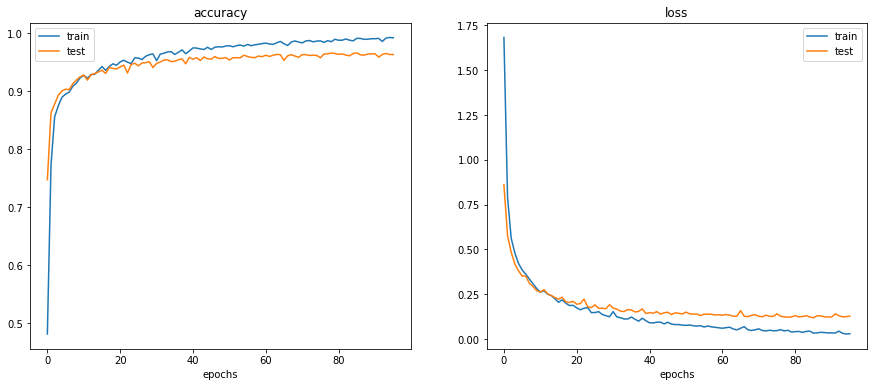

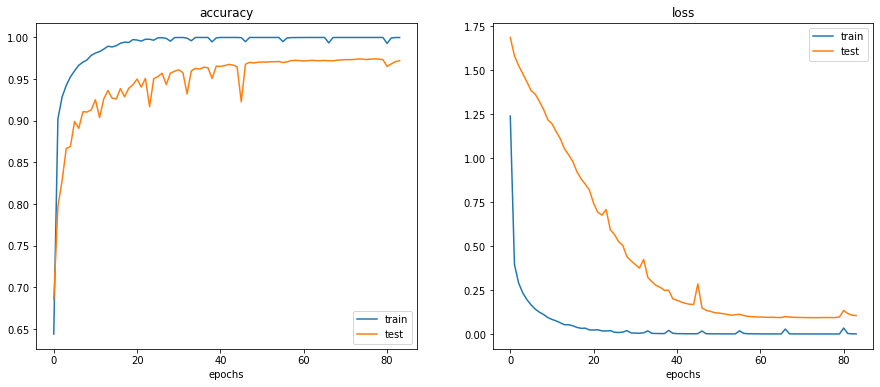

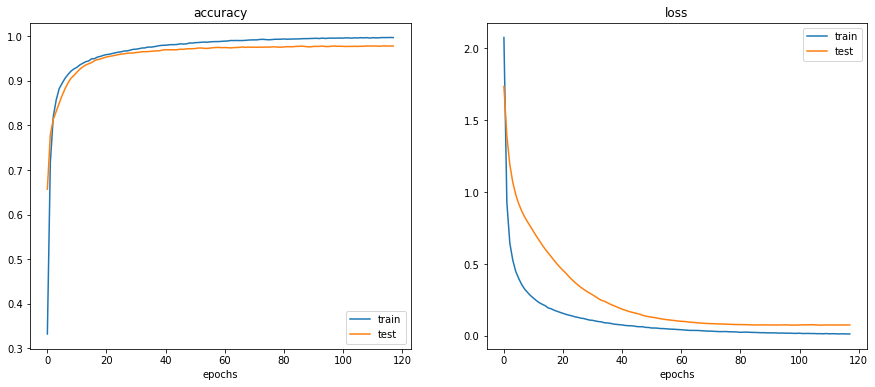

In [46]:
visualizer(hist_snn)
visualizer(hist_snn2)
visualizer(hist_snn3)

### 2. Сверточная сеть <a name="a006"></a>

Не смотря на итак уже весьма высокую точность решения задачи MNIST, попробуем натравить на цифры CNN

In [61]:
cnn = keras.Sequential(name = 'convolution_neural_net_1')
cnn.add(L.Input(shape = (28,28,1)))
cnn.add(L.Conv2D(4, kernel_size=(5,5), activation=tf.nn.relu))
cnn.add(L.MaxPool2D(strides=(2,2)))
cnn.add(L.Conv2D(16, kernel_size=(3,3), activation=tf.nn.relu))
cnn.add(L.Flatten())
cnn.add(L.Dense(1024, activation=tf.nn.relu))
cnn.add(L.Dense(256, activation=tf.nn.relu))
cnn.add(L.Dense(64, activation=tf.nn.relu))
cnn.add(L.Dense(10, activation=tf.nn.softmax))


In [62]:
cnn.summary()

Model: "convolution_neural_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 24, 24, 4)         104       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 4)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 16)        592       
_________________________________________________________________
flatten_14 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 1024)              1639424   
_________________________________________________________________
dense_45 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_46 (Dense)             (None, 64)   

In [65]:
cnn.compile(optimizer='rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [68]:
hist_cnn = cnn.fit(x=(train_images/255)[..., np.newaxis], y=train_labels, batch_size=10_000, epochs=100, verbose=1, 
        validation_split=0.2, callbacks=[early_stopping_monitor])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 11s 228us/sample - loss: 0.5491 - acc: 0.8273 - val_loss: 0.4452 - val_acc: 0.8612
Epoch 2/100
48000/48000 [==============================] - 11s 224us/sample - loss: 0.5750 - acc: 0.8075 - val_loss: 0.4137 - val_acc: 0.8819
Epoch 3/100
48000/48000 [==============================] - 11s 222us/sample - loss: 0.3696 - acc: 0.8921 - val_loss: 0.3553 - val_acc: 0.8931
Epoch 4/100
48000/48000 [==============================] - 11s 222us/sample - loss: 0.4063 - acc: 0.8663 - val_loss: 0.4559 - val_acc: 0.8567
Epoch 5/100
48000/48000 [==============================] - 11s 221us/sample - loss: 0.3453 - acc: 0.8913 - val_loss: 0.3416 - val_acc: 0.8855
Epoch 6/100
48000/48000 [==============================] - 11s 226us/sample - loss: 0.2800 - acc: 0.9101 - val_loss: 0.2050 - val_acc: 0.9402
Epoch 7/100
48000/48000 [==============================] - 11s 221us/sample - loss: 0.4179 - acc: 

48000/48000 [==============================] - 11s 229us/sample - loss: 0.0097 - acc: 0.9979 - val_loss: 0.0613 - val_acc: 0.9824
Epoch 59/100
48000/48000 [==============================] - 11s 226us/sample - loss: 0.1936 - acc: 0.9531 - val_loss: 0.0553 - val_acc: 0.9840
Epoch 60/100
48000/48000 [==============================] - 11s 228us/sample - loss: 0.0170 - acc: 0.9960 - val_loss: 0.0487 - val_acc: 0.9857
Epoch 61/100
48000/48000 [==============================] - 11s 232us/sample - loss: 0.0114 - acc: 0.9977 - val_loss: 0.0478 - val_acc: 0.9862
Epoch 62/100
48000/48000 [==============================] - 11s 227us/sample - loss: 0.0091 - acc: 0.9984 - val_loss: 0.0490 - val_acc: 0.9865
Epoch 63/100
48000/48000 [==============================] - 11s 223us/sample - loss: 0.0075 - acc: 0.9987 - val_loss: 0.0494 - val_acc: 0.9872
Epoch 64/100
48000/48000 [==============================] - 11s 227us/sample - loss: 0.0064 - acc: 0.9989 - val_loss: 0.0519 - val_acc: 0.9855
Epoch 65/100

In [69]:
accuracy_score(test_labels, cnn.predict_classes((test_images/255)[..., np.newaxis]))

0.9873

`Выводы`
* Великолпепная точность (с учетом того, что можно улучшить архитектуру)
* Много времени на обучение

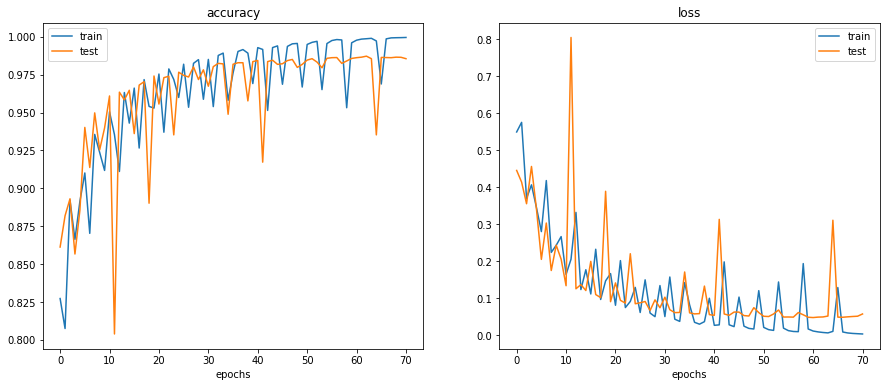

In [70]:
visualizer(hist_cnn)

**Добавим в CNN:** <a name="a007"></a>
* mini-batch normalization
* dropout
* he_normal initializations

In [91]:
cnn2 = keras.Sequential(name = 'convolution_neural_net_2')
cnn2.add(L.Input(shape = (28,28,1)))
cnn2.add(L.Conv2D(4, kernel_size=(5,5), activation=tf.nn.relu))
cnn2.add(L.MaxPool2D(strides=(2,2)))
cnn2.add(L.Conv2D(16, kernel_size=(3,3), activation=tf.nn.relu))
cnn2.add(L.Flatten())
cnn2.add(L.Dense(1024, activation=tf.nn.relu, kernel_initializer=keras.initializers.he_normal()))
cnn2.add(L.Dropout(0.2))
cnn2.add(L.BatchNormalization())
cnn2.add(L.Dense(256, activation=tf.nn.relu, kernel_initializer=keras.initializers.he_normal()))
cnn2.add(L.Dropout(0.2))
cnn2.add(L.BatchNormalization())
cnn2.add(L.Dense(64, activation=tf.nn.relu, kernel_initializer=keras.initializers.he_normal()))
cnn2.add(L.Dropout(0.2))
cnn2.add(L.BatchNormalization())
cnn2.add(L.Dense(10, activation=tf.nn.softmax))

cnn2.compile(optimizer='rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [92]:
cnn2.summary()

Model: "convolution_neural_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 24, 24, 4)         104       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 4)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 10, 10, 16)        592       
_________________________________________________________________
flatten_22 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 1024)              1639424   
_________________________________________________________________
dropout_23 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 1024) 

In [93]:
hist_cnn2 = cnn2.fit(x=(train_images/255)[..., np.newaxis], y=train_labels, batch_size=10_000, epochs=100, verbose=1, 
        validation_split=0.2, callbacks=[early_stopping_monitor])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 15s 306us/sample - loss: 1.1217 - acc: 0.6729 - val_loss: 1.6212 - val_acc: 0.8320
Epoch 2/100
48000/48000 [==============================] - 12s 258us/sample - loss: 0.3084 - acc: 0.9213 - val_loss: 1.5185 - val_acc: 0.9126
Epoch 3/100
48000/48000 [==============================] - 12s 258us/sample - loss: 0.2095 - acc: 0.9509 - val_loss: 1.4908 - val_acc: 0.9276
Epoch 4/100
48000/48000 [==============================] - 13s 265us/sample - loss: 0.1613 - acc: 0.9638 - val_loss: 1.4416 - val_acc: 0.9431
Epoch 5/100
48000/48000 [==============================] - 13s 260us/sample - loss: 0.1282 - acc: 0.9702 - val_loss: 1.3903 - val_acc: 0.9307
Epoch 6/100
48000/48000 [==============================] - 12s 257us/sample - loss: 0.1157 - acc: 0.9731 - val_loss: 1.3205 - val_acc: 0.9308
Epoch 7/100
48000/48000 [==============================] - 12s 257us/sample - loss: 0.0894 - acc: 

Epoch 58/100
48000/48000 [==============================] - 13s 269us/sample - loss: 0.0224 - acc: 0.9948 - val_loss: 0.1810 - val_acc: 0.9588
Epoch 59/100
48000/48000 [==============================] - 13s 267us/sample - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1635 - val_acc: 0.9614
Epoch 60/100
48000/48000 [==============================] - 13s 267us/sample - loss: 5.9749e-04 - acc: 1.0000 - val_loss: 0.1537 - val_acc: 0.9635
Epoch 61/100
48000/48000 [==============================] - 12s 258us/sample - loss: 6.5590e-04 - acc: 0.9999 - val_loss: 0.1459 - val_acc: 0.9666
Epoch 62/100
48000/48000 [==============================] - 12s 259us/sample - loss: 7.0086e-04 - acc: 0.9999 - val_loss: 0.1294 - val_acc: 0.9705
Epoch 63/100
48000/48000 [==============================] - 12s 258us/sample - loss: 5.4481e-04 - acc: 0.9999 - val_loss: 0.1358 - val_acc: 0.9675
Epoch 64/100
48000/48000 [==============================] - 12s 258us/sample - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1389 -

In [94]:
accuracy_score(test_labels, cnn2.predict_classes((test_images/255)[..., np.newaxis]))

0.988

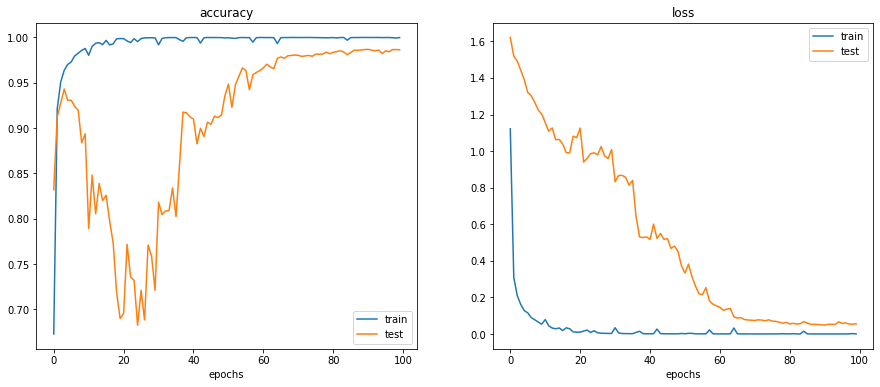

In [95]:
visualizer(hist_cnn2)

### 4.1 Визуализация архитектуры сети<a name="a008"></a>

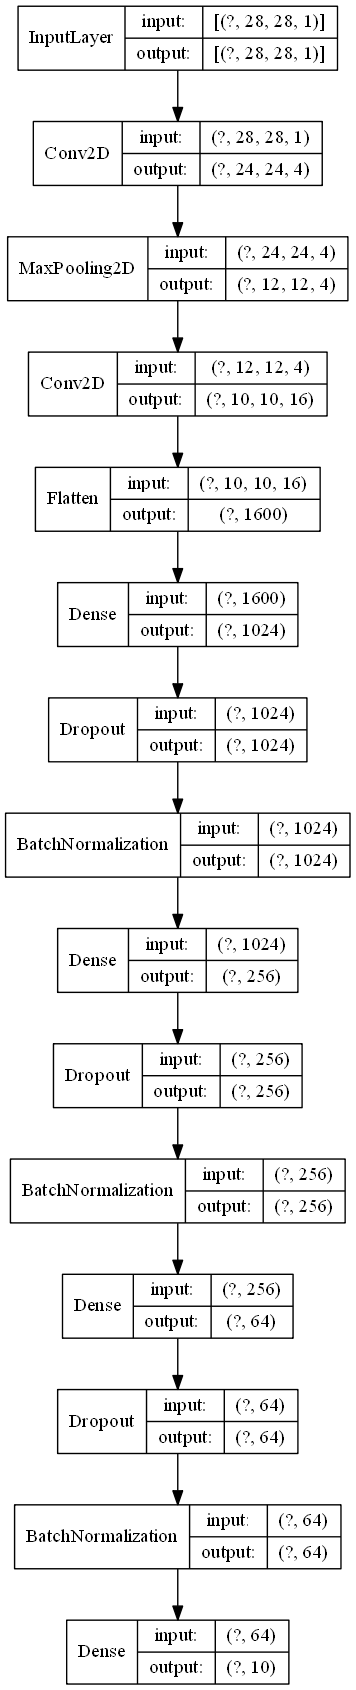

In [132]:
keras.utils.plot_model(cnn2, to_file='CNN2.png', 
                       show_shapes=True, # Показывать размерность входов и выходов слоя
                       show_layer_names = False, # Показывать имена слоев
                       dpi=100)

### 4.2 Сохранение и загрузка архитектуры сети и весов<a name="a009"></a>

Подробнее тут - https://keras.io/getting-started/faq/

In [133]:
cnn2.save('cnn2.h5') # Сохраним архитектуру модели (и веса)

In [134]:
cnn2.save_weights('cnn2_weights.h5') # Сохраним отдельно веса

In [139]:
keras.models.load_model('cnn2.h5') # Загрузка модели с весами

In [140]:
#cnn2.load_weights() # Загрузка весов, параметр by_name позволяет загружать для каждого слоя свои веса по его имени